# PySDR接收信号初探

作者：Mindstorm (brainstorm233@qq.com)

时间：2024.5.5

参考：
1. PlutoSDR in Python https://pysdr.org/content/pluto.html
2. ChatGPT4 http://chat.openai.com/
3. ADALM-PLUTO Overview https://wiki.analog.com/university/tools/pluto

## 【例程一】测试连接

In [ ]:
# 若返回一组复数向量，则pluto正常工作
import adi
sdr = adi.Pluto('ip:192.168.2.1') # or whatever your Pluto's IP is
sdr.sample_rate = int(2.5e6)
sdr.rx()

## 【例程二】采集信号并打印前十个值

In [ ]:
import adi

sample_rate = 1e6 # Hz
center_freq = 100e6 # Hz
num_samps = 10000 # number of samples returned per call to rx()

sdr = adi.Pluto('ip:192.168.2.1')
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 70.0 # dB
sdr.rx_lo = int(center_freq)
sdr.sample_rate = int(sample_rate)
sdr.rx_rf_bandwidth = int(sample_rate) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size = num_samps

samples = sdr.rx() # receive samples off Pluto
print(samples[0:10])

## 【例程三】边发边收一个QPSK信号

In [ ]:
import numpy as np
import adi
import matplotlib.pyplot as plt

sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -50 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Create transmit waveform (QPSK, 16 samples per symbol)
num_symbols = 1000
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
samples = np.repeat(x_symbols, 16) # 16 samples per symbol (rectangular pulses)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(samples) # start transmitting

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print(rx_samples)

# Stop transmitting
sdr.tx_destroy_buffer()

# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot time domain
plt.figure(0)
plt.plot(np.real(rx_samples[::100]))
plt.plot(np.imag(rx_samples[::100]))
plt.xlabel("Time")

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()

## 显示频谱

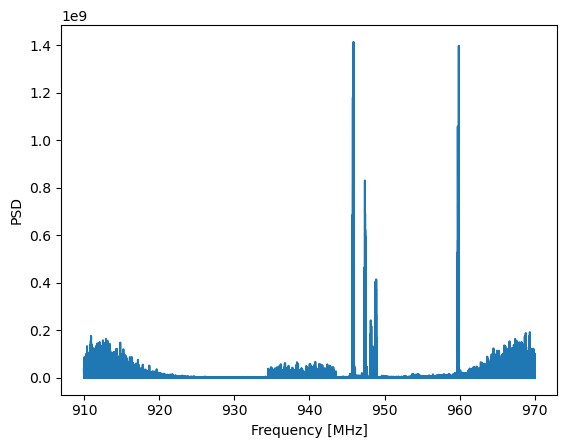

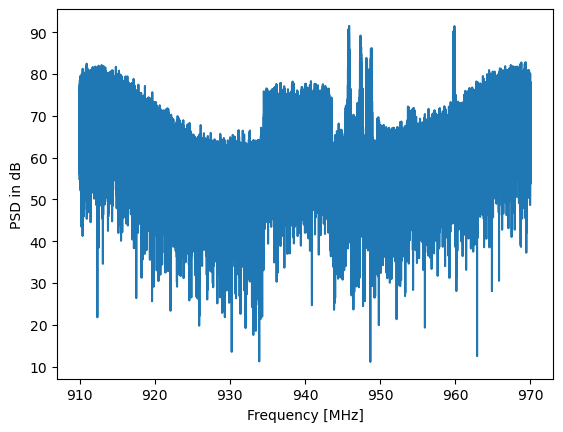

In [26]:
import numpy as np
import adi
import matplotlib.pyplot as plt

def receive_and_plot_power_spectrum(start_freq, end_freq):
    sample_rate = end_freq - start_freq  # Hz
    if sample_rate >= 61.44e6:
        raise ValueError('Sample Rate must be less than 61.44MHz!')
    if sample_rate <= 0:
        raise ValueError('Sample Rate must not be a negative number!')
    center_freq = (start_freq + end_freq) / 2  # Center frequency
    num_samps = 100000  # number of samples per call to rx()

    sdr = adi.Pluto("ip:192.168.2.1")
    sdr.sample_rate = int(sample_rate)

    # Config Rx
    sdr.rx_lo = int(center_freq)
    sdr.rx_rf_bandwidth = int(sample_rate)
    sdr.rx_buffer_size = num_samps
    sdr.gain_control_mode_chan0 = 'manual'
    sdr.rx_hardwaregain_chan0 = 0.0  # dB, increase to increase the receive gain, but be careful not to saturate the ADC

    # Clear buffer just to be safe
    for i in range(0, 10):
        raw_data = sdr.rx()

    # Receive samples
    rx_samples = sdr.rx()

    # Calculate power spectral density (frequency domain version of signal)
    psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples))) ** 2
    psd_dB = 10 * np.log10(psd)
    f = np.linspace(start_freq, end_freq, len(psd))

    # Plot freq domain
    plt.figure(0)
    plt.plot(f / 1e6, psd)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD")
    plt.show()

    # Plot freq domain
    plt.figure(1)
    plt.plot(f / 1e6, psd_dB)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD in dB")
    plt.show()

# Example usage
start_frequency = 910e6
end_frequency = 970e6
receive_and_plot_power_spectrum(start_frequency, end_frequency)

## 存储频谱到.mat文件

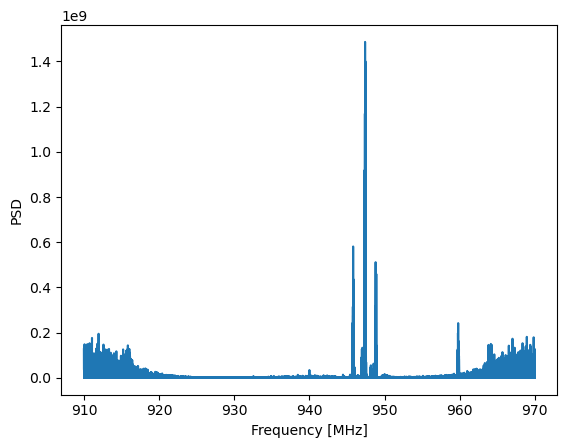

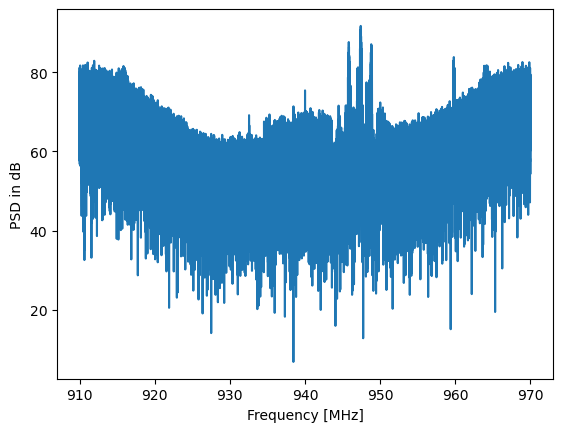

In [28]:
import numpy as np
import adi
import matplotlib.pyplot as plt
from scipy.io import savemat
from datetime import datetime

def receive_and_plot_power_spectrum(start_freq, end_freq):
    sample_rate = end_freq - start_freq  # Hz
    if sample_rate >= 61.44e6:
        raise ValueError('Sample Rate must be less than 61.44MHz!')
    if sample_rate <= 0:
        raise ValueError('Sample Rate must not be a negative number!')
    center_freq = (start_freq + end_freq) / 2  # Center frequency
    num_samps = 100000  # number of samples per call to rx()

    sdr = adi.Pluto("ip:192.168.2.1")
    sdr.sample_rate = int(sample_rate)

    # Config Rx
    sdr.rx_lo = int(center_freq)
    sdr.rx_rf_bandwidth = int(sample_rate)
    sdr.rx_buffer_size = num_samps
    sdr.gain_control_mode_chan0 = 'manual'
    sdr.rx_hardwaregain_chan0 = 0.0  # dB, increase to increase the receive gain, but be careful not to saturate the ADC

    # Clear buffer just to be safe
    for i in range(0, 10):
        raw_data = sdr.rx()

    # Receive samples
    rx_samples = sdr.rx()

    # Calculate power spectral density (frequency domain version of signal)
    psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples))) ** 2
    psd_dB = 10 * np.log10(psd)
    f = np.linspace(start_freq, end_freq, len(psd))

    # Plot freq domain
    plt.figure(0)
    plt.plot(f / 1e6, psd)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD")
    plt.show()

    # Plot freq domain
    plt.figure(1)
    plt.plot(f / 1e6, psd_dB)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD in dB")
    plt.show()

    # Save data to .mat file
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    filename = timestamp + ".mat"
    savemat(filename, {'f': f, 'psd': psd, 'psd_dB': psd_dB})

# Example usage
start_frequency = 910e6
end_frequency = 970e6
receive_and_plot_power_spectrum(start_frequency, end_frequency)